## ***Project 1: PINNs for parametric problems vs Greedy (Advection-Diffusion equation)*** ###

Train a PINN to solve the following parametric problem on
${\Omega} = (0, 1) \times (0, 1)$

$$
\begin{cases}
\nabla \cdot ({\mu_1} \nabla u) + \boldsymbol{\beta}\cdot \nabla{u}= 0 & \text{in } \Omega,\\
{\mu_1} \nabla u \cdot \mathbf{n} = \mu_2 & \text{in } \Gamma_{b},\\
u = 0 & \text{in } \Gamma_{tl},\\
 \nabla u \cdot \mathbf{n} = 0 & \text{otherwise},
\end{cases}
$$

where $\mathbf{n}$ is the outer-normal to the portion of $\partial \Omega$ we consider.
Specifically, $\Gamma_b = [0, 1] \times \{0\}$ and $\Gamma_{tl} = ([0, 1] \times \{1\}) \cup (\{0\} \times [0,1])$.

The convection field is $\boldsymbol{\beta} = [y(1-y),0]^T$ and $(x,y)$ represent a spatial coordinate in $\Omega$.
The parametric space is $\mathcal P = [0.1, 10] \times [-1,1]$.


Compare the results with standard ROM based on Greedy approach, both in terms of online  accuracy with respect to the FE solutions, speedups and offline computations compared with the training phase.

**Hints!**

1. Given a neural network $\tilde {w} (\mathbf x)$, the loss will be of the form
  $$
      MSE^{\boldsymbol \mu}  \doteq MSE_b^{\boldsymbol \mu} + MSE_p^{\boldsymbol \mu}.
  $$
  where the boundary MSE is:
  $$
          MSE_b^{\boldsymbol \mu} \doteq \frac{1}{N_b} \sum_{k=1}^{N_b} | \tilde{w}(\mathbf x_k^b) - w(\mathbf x_k^b)|^2,
  $$
  for $\mathbf x_k^b \in \partial \Omega \times \mathcal P$.

  While the physical MSE is
      \begin{equation*}
          MSE_{p}^{\boldsymbol \mu} \doteq \frac{1}{N_p}\sum_{k=1}^{N_p}|\mathcal R(\tilde{w}(\mathbf x_k^p))|^2,
      \end{equation*}

  where $\mathbf x_k^p \in \Omega \times \mathcal P$.
2. Be careful in evaluating the coercivity constant for the greedy procedure.
  For Advection-Diffusion problems the coercivity constant with respect the $H^1_0(\Omega)$ _norm_ can be approximated by
  $$
  \frac{\mu_1}{1 + C_{\Omega}^2},
  $$
  where $C_{\Omega}$ is the Poincaré constant, i.e. the constant verifying
  $$\lvert \lvert u \rvert \rvert_{L^2(\Omega)} \leq C_{\Omega} \lvert \lvert \nabla u \rvert \rvert_{L^2(\Omega)}.$$

  The Poincaré constant can be approximated by the following eigenvalue problem: $ \mathbb X_{H^1_{\text{semi-norm}}} \mathbf x = \lambda \mathbb X_{L^2_{\text{norm}}}\mathbf x$.

  Coding-wise, you can use `scipy` as follows on the inner product and reaction matrix to find $C_{\Omega}$:

# Build a data set

In [15]:
from google.colab import files
import numpy as np
import pandas as pd

# Define mu1, mu2
# np.random.seed(2)

# n_mu2 = 5

# mu2 = np.concatenate((np.array([-0.6, -0.1, 0.3, 0.7]), np.flip(-np.logspace(-6, 0., num=n_mu2)), np.logspace(-6, 0., num=n_mu2)), axis = 0)

# mu1 = np.random.exponential(scale=4.0, size=(20))
#mu1 = mu1[(mu1 >= 0.1)]
#mu1 = mu1[(mu1 <= 10)]
#n_mu1 = len(mu1)
#n_mu2 = len(mu2)

#xv, yv = np.meshgrid(mu1, mu2)
#xv = xv.reshape((xv.shape[0] * xv.shape[1] ))
#yv = yv.reshape((yv.shape[0] * yv.shape[1] ))

#df = pd.DataFrame(dict(mu1=xv,mu2=yv,ratio=abs(yv/xv)))


#df.to_csv("data.csv",sep = ';', header=True)

#files.download('./data.csv')

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/data.csv', sep=';')
df.describe()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,mu1,mu2,ratio
count,280.000000,280.000000,280.000000,2.800000e+02
mean,139.500000,2.734084,0.021429,3.004378e-01
std,80.973247,2.150389,0.459513,1.026337e+00
min,0.000000,0.105073,-1.000000,1.299390e-07
25%,69.750000,1.160093,-0.031623,3.226314e-05
50%,139.500000,2.288385,0.000000,1.357083e-02
75%,209.250000,3.358941,0.031623,2.195342e-01
max,279.000000,7.695918,1.000000,9.517196e+00


In [2]:
# x and y given as array_like objects
import plotly.express as px
import plotly.graph_objects as go

fig = px.box(df.mu1,points="all")
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show()
fig = px.box(df.mu2,points="all")
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

import matplotlib.pyplot as plt



fig = px.scatter(df, x="mu1", y="mu2", color = "ratio")
fig.show()

fig = px.box(df.ratio,points="all")
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.show()


In [5]:
!pip install pyevtk

import numpy as np
from pyevtk.hl import pointsToVTK, unstructuredGridToVTK
from pyevtk.vtk import VtkPolygon, VtkLine

def export_cells_0(path_file: str, x: float, y: float, point_data):
    pointsToVTK(path_file, x, y, np.zeros(x.shape), data=point_data)

def export_solution(path_file: str, numeric_solution, cell0DExactSolution, x, y):
    point_data = {"numeric_solution": numeric_solution, "fem_solution": cell0DExactSolution }
    export_cells_0(path_file, x, y, point_data)

# Full order model

In [6]:
!git clone https://github.com/fvicini/CppToPython.git
%cd CppToPython

Cloning into 'CppToPython'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 645 (delta 31), reused 50 (delta 17), pack-reused 487
Receiving objects: 100% (645/645), 596.41 KiB | 6.15 MiB/s, done.
Resolving deltas: 100% (424/424), done.
/content/CppToPython


In [7]:
!git submodule init
!git submodule update

Submodule 'gedim' (https://github.com/fvicini/gedim.git) registered for path 'gedim'
Cloning into '/content/CppToPython/gedim'...
Submodule path 'gedim': checked out 'c52847f1a527d36b529f39d3744afe9fd612b62c'


In [ ]:
!mkdir -p externals
%cd externals
!cmake -DINSTALL_VTK=OFF -DINSTALL_LAPACK=OFF ../gedim/3rd_party_libraries
!make -j4
%cd ..

In [ ]:
!mkdir -p release
%cd release
!cmake -DCMAKE_PREFIX_PATH="/content/CppToPython/externals/Main_Install/eigen3;/content/CppToPython/externals/Main_Install/triangle;/content/CppToPython/externals/Main_Install/tetgen;/content/CppToPython/externals/Main_Install/googletest" ../
!make -j4 GeDiM4Py
%cd ..

In [10]:
import numpy as np
import GeDiM4Py as gedim

In [11]:
lib = gedim.ImportLibrary("./release/GeDiM4Py.so")
geometricTolerance = 1.0e-8
config = { 'GeometricTolerance': geometricTolerance }
gedim.Initialize(config, lib)

## Define mesh

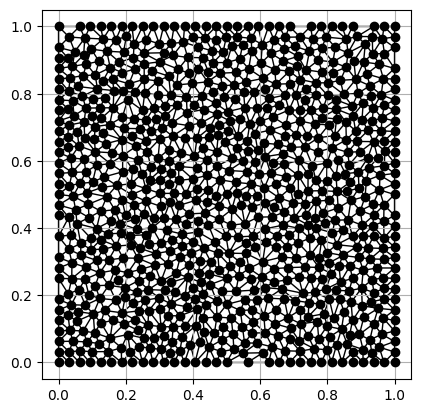

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
meshSize = 0.001
order = 1

domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,0,1,1], 'EdgesBoundaryCondition': [2,3,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

gedim.PlotMesh(mesh)

df_solution = pd.DataFrame(mesh.T)
df_solution.to_csv('mesh001.csv', sep = ';', header=True)
files.download('./mesh001.csv')

## Define discretization

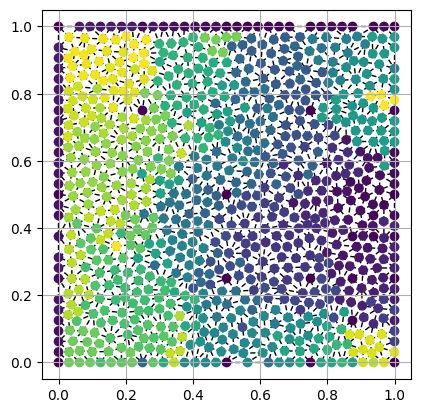

In [28]:
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2, 3, 3] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)
gedim.PlotDofs(mesh, dofs, strongs)

## Assemble and solve the problem

In [30]:
solution = np.zeros((dofs.shape[1], len(df.mu1)))


for i in range(len(df.mu1)):

    mu1_test = df.mu1[i]
    mu2_test = df.mu2[i]

    def Poisson_mu1(numPoints, points):
      values = np.ones(numPoints) * mu1_test
      return values.ctypes.data

    def Poisson_mu2(numPoints, points):
      values = np.ones(numPoints) * mu2_test
      return values.ctypes.data

    def Poisson_beta(numPoints, points):
      matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
      values = np.zeros((2, numPoints))
      values[0,:] = (1.0 - matPoints[1,:]) * matPoints[1,:]
      return values.ctypes.data

    def Poisson_f(numPoints, points):
      values = np.zeros(numPoints)
      return values.ctypes.data

    def Poisson_strongTerm(numPoints, points):
      values = np.zeros(numPoints)
      return values.ctypes.data

    def Poisson_weakTerm_right(numPoints, points):
      values = np.zeros(numPoints)
      return values.ctypes.data

    def Poisson_weakTerm_bottom(numPoints, points):
      return Poisson_mu2(numPoints, points)



    [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Poisson_mu1, problemData, lib)

    [advection, advectionStrong] = gedim.AssembleAdvectionMatrix(Poisson_beta, problemData, lib)

    forcingTerm = gedim.AssembleForcingTerm(Poisson_f, problemData, lib)

    solutionStrong = gedim.AssembleStrongSolution(Poisson_strongTerm, 1, problemData, lib)

    weakTerm_bottom = gedim.AssembleWeakTerm(Poisson_weakTerm_bottom, 2, problemData, lib)
    weakTerm_right = gedim.AssembleWeakTerm(Poisson_weakTerm_right, 3, problemData, lib)

    solution[:, i] = gedim.LUSolver(stiffness + advection, \
        forcingTerm - \
        (stiffnessStrong + advectionStrong) @ solutionStrong + \
        weakTerm_right + \
        weakTerm_bottom, lib)

df_solution = pd.DataFrame(solution)
df_solution.to_csv('solutionValues.csv', sep = ';', header=True)
files.download('./solutionValues.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Solve

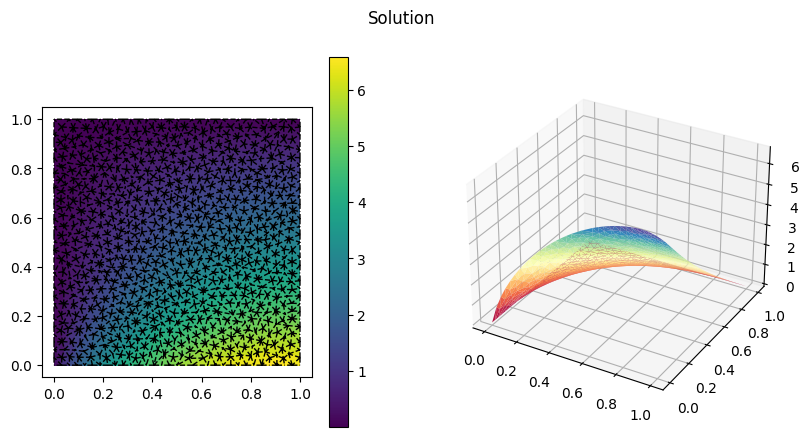

In [257]:
gedim.PlotSolution(mesh, dofs, strongs, solution, solutionStrong)

# PINN

## Define a data sets: training and test

In [37]:
df_solution = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/solutionValues.csv', sep=';')

df['max_solution'] = np.array(df_solution.abs().max())[1:]

df.describe()

fig = px.scatter(x=df.ratio, y=df.max_solution)
fig.show()

## Train the NN

In [18]:
#### starting stuff ####

import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        num_nodes = 20
        self.input_layer = nn.Linear(4, num_nodes)
        self.hidden_layer1 = nn.Linear(num_nodes, num_nodes)
        self.hidden_layer2 = nn.Linear(num_nodes, num_nodes)
        self.hidden_layer3 = nn.Linear(num_nodes, num_nodes)
        #self.hidden_layer4 = nn.Linear(num_nodes, num_nodes)
        self.output_layer = nn.Linear(num_nodes, 1)

    def forward(self, x, y, mu1, mu2):
        input = torch.cat([x, y, mu1, mu2],axis=1) # combines the column array
        layer1_out = torch.sigmoid(self.input_layer(input))
        layer2_out = torch.sigmoid(self.hidden_layer1(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer2(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer3(layer3_out))
        #layer5_out = torch.sigmoid(self.hidden_layer4(layer4_out))
        output = self.output_layer(layer4_out)
        return output


## PDE as loss function. Thus would use the network which we call as u_theta
def R(x, y, mu1, mu2, net):
    u = net(x, y, mu1, mu2) # the dependent variable u is given by the network based on independent variables x,t
    ## Based on our R = du/dx - 2du/dt - u, we need du/dx and du/dt
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y.sum(), y, create_graph=True)[0]

    pde = mu1 * (u_xx + u_yy) + y * (1-y) * u_x

    return pde

def Neumann_bottom(pt_x_bc_N_bottom, pt_y_bc_N_bottom, pt_mu1_N_bottom, pt_mu2_N_bottom, net):
    u = net(pt_x_bc_N_bottom, pt_y_bc_N_bottom, pt_mu1_N_bottom, pt_mu2_N_bottom)
    u_x = torch.autograd.grad(u.sum(), pt_x_bc_N_bottom, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), pt_y_bc_N_bottom, create_graph=True)[0]
    neumann = - pt_mu1_N_bottom * u_y - pt_mu2_N_bottom
    return neumann

def Neumann_right(pt_x_bc_N_right, pt_y_bc_N_right, pt_mu1_N_right, pt_mu2_N_right, net):
    u = net(pt_x_bc_N_right,pt_y_bc_N_right, pt_mu1_N_right, pt_mu2_N_right)
    u_x = torch.autograd.grad(u.sum(), pt_x_bc_N_right, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), pt_y_bc_N_right, create_graph=True)[0]
    neumann = u_x
    return neumann

In [34]:
#@title Testo del titolo predefinito
from numpy.core.multiarray import ndarray
import matplotlib.pyplot as plt
from scipy.stats import qmc

## Data from Boundary Conditions


random_seed = 1
torch.manual_seed(random_seed)

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_D_upper = 500
n_D_left = 500

n_N_bottom = 500
n_N_right = 500
num_points = 500

tol = 1.0e-07
mtol = 1. - 1.0e-07

# Dirichlet upper
# Take n_D_upper random points upper
x_bc_D_upper = np.random.uniform(low=0., high=1., size=(n_D_upper,1))
y_bc_D_upper = np.ones((n_D_upper,1))
# compute u
u_bc_D_upper = np.zeros((n_D_left,1))

x_bc_D_upper = np.ravel(np.squeeze(np.concatenate([([x_bc_D_upper] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)
y_bc_D_upper = np.ravel(np.squeeze(np.concatenate([([y_bc_D_upper] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)
u_bc_D_upper = np.ravel(np.squeeze(np.concatenate([([u_bc_D_upper] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)

# Dirichlet left
# Take n_D_left random points left
x_bc_D_left = np.zeros((n_D_left,1))
y_bc_D_left = np.random.uniform(low=0., high=1., size=(n_D_left,1))
# compute u
u_bc_D_left = np.zeros((n_D_left,1))

x_bc_D_left = np.ravel(np.squeeze(np.concatenate([([x_bc_D_left] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)
y_bc_D_left = np.ravel(np.squeeze(np.concatenate([([y_bc_D_left] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)
u_bc_D_left = np.ravel(np.squeeze(np.concatenate([([u_bc_D_left] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)

# Dirichlet v1
x_v1 = np.zeros((n_mu1 * n_mu2, 1))
y_v1 = np.zeros((n_mu1 * n_mu2, 1))
# compute u
u_v1 = np.zeros((n_mu1 * n_mu2, 1))

# Dirichlet v3
x_v3 = np.ones((n_mu1 * n_mu2,1))
y_v3 = np.ones((n_mu1 * n_mu2,1))
# compute u
u_v3 = np.zeros((n_mu1 * n_mu2,1))

# Dirichlet v4
x_v4 = np.zeros((n_mu1 * n_mu2,1))
y_v4 = np.ones((n_mu1 * n_mu2,1))
# compute u
u_v4 = np.zeros((n_mu1 * n_mu2,1))

# Neuman: right
x_bc_N_right = np.ones((n_N_right * n_mu1 * n_mu2,1))
y_bc_N_right = np.random.uniform(low=tol, high=mtol, size=(n_N_right,1))
y_bc_N_right = np.ravel(np.squeeze(np.concatenate([([y_bc_N_right] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)


# Neumann: bottom
x_bc_N_bottom = np.random.uniform(low=tol, high=mtol, size=(n_N_bottom,1))
x_bc_N_bottom = np.ravel(np.squeeze(np.concatenate([([x_bc_N_bottom] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)
y_bc_N_bottom = np.zeros((n_N_bottom * n_mu1 * n_mu2,1))


### (2) Model
net = Net()
mse_cost_function = torch.nn.MSELoss() # Mean squared error

optimizer = torch.optim.Adam(net.parameters())

### (3) Training / Fitting

print("######### PRETRAIN #############")


iterations = 10000
sampler = qmc.Halton(d=2, scramble=False)
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero

    # Loss based on vertices:

    mu1_D_v = np.ravel(np.array([mu1] * n_mu2)).reshape(-1,1)
    mu2_D_v = np.ravel(np.concatenate([([mu] * n_mu1 ) for mu in mu2], axis=0)).reshape(-1,1)
    pt_mu1_D_v = Variable(torch.from_numpy(mu1_D_v).float(), requires_grad=False)
    pt_mu2_D_v = Variable(torch.from_numpy(mu2_D_v).float(), requires_grad=False)

    pt_x_v1 = Variable(torch.from_numpy(x_v1).float(), requires_grad=False)
    pt_y_v1 = Variable(torch.from_numpy(y_v1).float(), requires_grad=False)
    pt_u_v1 = Variable(torch.from_numpy(u_v1).float(), requires_grad=False)

    net_v1 = net(pt_x_v1, pt_y_v1, pt_mu1_D_v, pt_mu2_D_v) # output of u(x,t)
    mse_v1 = mse_cost_function(net_v1, pt_u_v1) # boundary MSE

    pt_x_v3 = Variable(torch.from_numpy(x_v3).float(), requires_grad=False)
    pt_y_v3 = Variable(torch.from_numpy(y_v3).float(), requires_grad=False)
    pt_u_v3 = Variable(torch.from_numpy(u_v3).float(), requires_grad=False)

    net_v3 = net(pt_x_v3, pt_y_v3, pt_mu1_D_v, pt_mu2_D_v) # output of u(x,t)
    mse_v3 = mse_cost_function(net_v3, pt_u_v3) # boundary MSE

    pt_x_v4 = Variable(torch.from_numpy(x_v4).float(), requires_grad=False)
    pt_y_v4 = Variable(torch.from_numpy(y_v4).float(), requires_grad=False)
    pt_u_v4 = Variable(torch.from_numpy(u_v4).float(), requires_grad=False)

    net_v4 = net(pt_x_v4, pt_y_v4, pt_mu1_D_v, pt_mu2_D_v) # output of u(x,t)
    mse_v4 = mse_cost_function(net_v4, pt_u_v4) # boundary MSE

    # Loss based on boundary conditions: Dirichlet upper
    mu1_D_upper = np.concatenate([([mu] * n_D_upper) for mu in mu1], axis=0)
    mu1_D_upper = np.reshape(np.repeat(mu1_D_upper, n_mu2, axis=1),(n_D_upper * n_mu1 * n_mu2, 1), order='F')
    mu2_D_upper = np.concatenate([([mu] * n_D_upper) for mu in mu2], axis=0)
    mu2_D_upper = np.ravel(np.repeat(mu2_D_upper, n_mu1)).reshape(-1,1)
    pt_mu1_D_upper = Variable(torch.from_numpy(mu1_D_upper).float(), requires_grad=False)
    pt_mu2_D_upper = Variable(torch.from_numpy(mu2_D_upper).float(), requires_grad=False)

    pt_x_bc_D_upper = Variable(torch.from_numpy(x_bc_D_upper).float(), requires_grad=False)
    pt_y_bc_D_upper = Variable(torch.from_numpy(y_bc_D_upper).float(), requires_grad=False)
    pt_u_bc_D_upper = Variable(torch.from_numpy(u_bc_D_upper).float(), requires_grad=False)

    net_bc_out_D_upper = net(pt_x_bc_D_upper, pt_y_bc_D_upper,pt_mu1_D_upper, pt_mu2_D_upper) # output of u(x,t)
    mse_bc_D_upper = mse_cost_function(net_bc_out_D_upper, pt_u_bc_D_upper) # boundary MSE

    # Loss based on boundary conditions: Dirichlet left
    mu1_D_left = np.concatenate([([mu] * n_D_left) for mu in mu1], axis=0)
    mu1_D_left = np.reshape(np.repeat(mu1_D_left, n_mu2, axis=1),(n_D_left * n_mu1 * n_mu2, 1), order='F')
    mu2_D_left = np.concatenate([([mu] * n_D_left) for mu in mu2], axis=0)
    mu2_D_left = np.ravel(np.repeat(mu2_D_left, n_mu1)).reshape(-1,1)
    pt_mu1_D_left = Variable(torch.from_numpy(mu1_D_left).float(), requires_grad=False)
    pt_mu2_D_left = Variable(torch.from_numpy(mu2_D_left).float(), requires_grad=False)

    pt_x_bc_D_left = Variable(torch.from_numpy(x_bc_D_left).float(), requires_grad=False)
    pt_y_bc_D_left = Variable(torch.from_numpy(y_bc_D_left).float(), requires_grad=False)
    pt_u_bc_D_left = Variable(torch.from_numpy(u_bc_D_left).float(), requires_grad=False)

    net_bc_out_D_left = net(pt_x_bc_D_left, pt_y_bc_D_left, pt_mu1_D_left, pt_mu2_D_left) # output of u(x,t)
    mse_bc_D_left = mse_cost_function(net_bc_out_D_left, pt_u_bc_D_left) # boundary MSE

    # Loss based on boundary conditions: Neumann right
    mu1_N_right = np.concatenate([([mu] * n_N_right) for mu in mu1], axis=0)
    mu1_N_right = np.reshape(np.repeat(mu1_N_right, n_mu2, axis=1),(n_N_right * n_mu1 * n_mu2, 1), order='F')
    mu2_N_right = np.concatenate([([mu] * n_N_right) for mu in mu2], axis=0)
    mu2_N_right = np.ravel(np.repeat(mu2_N_right, n_mu1)).reshape(-1,1)
    pt_mu1_N_right = Variable(torch.from_numpy(mu1_N_right).float(), requires_grad=False)
    pt_mu2_N_right = Variable(torch.from_numpy(mu2_N_right).float(), requires_grad=False)

    pt_x_bc_N_right = Variable(torch.from_numpy(x_bc_N_right).float(), requires_grad=True)
    pt_y_bc_N_right = Variable(torch.from_numpy(y_bc_N_right).float(), requires_grad=True)

    net_neumann_right = Neumann_right(pt_x_bc_N_right, pt_y_bc_N_right, pt_mu1_N_right, pt_mu2_N_right, net)
    zero_n_right = np.zeros((n_N_right * n_mu1 * n_mu2, 1))
    pt_zero_n_right = Variable(torch.from_numpy(zero_n_right).float(), requires_grad=False)
    mse_bc_N_right = mse_cost_function(net_neumann_right, pt_zero_n_right)

    # Loss based on boundary conditions: Neumann bottom
    mu1_N_bottom = np.concatenate([([mu] * n_N_bottom) for mu in mu1], axis=0)
    mu1_N_bottom = np.reshape(np.repeat(mu1_N_bottom, n_mu2, axis=1),(n_N_bottom * n_mu1 * n_mu2, 1), order='F')
    mu2_N_bottom = np.concatenate([([mu] * n_N_bottom) for mu in mu2], axis=0)
    mu2_N_bottom = np.ravel(np.repeat(mu2_N_bottom, n_mu1)).reshape(-1,1)
    pt_mu1_N_bottom = Variable(torch.from_numpy(mu1_N_bottom).float(), requires_grad=False)
    pt_mu2_N_bottom = Variable(torch.from_numpy(mu2_N_bottom).float(), requires_grad=False)

    pt_x_bc_N_bottom = Variable(torch.from_numpy(x_bc_N_bottom).float(), requires_grad=True)
    pt_y_bc_N_bottom = Variable(torch.from_numpy(y_bc_N_bottom).float(), requires_grad=True)

    net_neumann_bottom = Neumann_bottom(pt_x_bc_N_bottom, pt_y_bc_N_bottom, pt_mu1_N_bottom, pt_mu2_N_bottom, net)
    zero_n_bottom = np.zeros((n_N_bottom * n_mu1 * n_mu2,1))
    pt_zero_n_bottom = Variable(torch.from_numpy(zero_n_bottom).float(), requires_grad=False)
    mse_bc_N_bottom = mse_cost_function(net_neumann_bottom, pt_zero_n_bottom)

    # Loss based on PDE
    #l_bounds = [tol, tol]
    #u_bounds = [1., 1.]
    #sample = sampler.random(n = num_points)
    #sample = qmc.scale(sample, l_bounds, u_bounds)
    #x_collocation = np.ravel(sample[:,0]).reshape(-1,1)
    #y_collocation = np.ravel(sample[:,1]).reshape(-1,1)
    mu1_collocation = np.concatenate([([mu] * num_points) for mu in mu1], axis=0)
    mu1_collocation = np.reshape(np.repeat(mu1_collocation, n_mu2, axis=1),(num_points * n_mu1 * n_mu2, 1), order='F')
    mu2_collocation = np.concatenate([([mu] * num_points) for mu in mu2], axis=0)
    mu2_collocation = np.ravel(np.repeat(mu2_collocation, n_mu1)).reshape(-1,1)
    pt_mu1_collocation = Variable(torch.from_numpy(mu1_collocation).float(), requires_grad=False)
    pt_mu2_collocation = Variable(torch.from_numpy(mu2_collocation).float(), requires_grad=False)

    x_collocation = np.random.uniform(low=0.0, high=1.0, size=(num_points,1))
    y_collocation = np.random.uniform(low=0.0, high=1.0, size=(num_points,1))
    x_collocation = np.ravel(np.squeeze(np.concatenate([([x_collocation] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)
    y_collocation = np.ravel(np.squeeze(np.concatenate([([y_collocation] * n_mu1 ) for i in range(n_mu2)], axis=0))).reshape(-1,1)
    all_zeros = np.zeros((num_points * n_mu1 * n_mu2,1))

    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True)
    pt_y_collocation = Variable(torch.from_numpy(y_collocation).float(), requires_grad=True)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False)

    f_out = R(pt_x_collocation, pt_y_collocation, pt_mu1_collocation, pt_mu2_collocation, net) # output of R(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)

    # Combining the loss functions
    weights = np.array([1, 1, 1, 1, 1, 1, 1, 1])
    loss = (weights[0] * mse_v1 + weights[1] * mse_v3 + weights[2] * mse_v4 + weights[3] * mse_bc_D_upper + weights[4] * mse_bc_D_left + weights[5] * mse_bc_N_bottom + weights[6] * mse_bc_N_right + weights[7] * mse_f)/ np.sum(weights)

    loss.backward()
    optimizer.step()

    with torch.autograd.no_grad():
      if( epoch % 200 == 0):
        #plt.figure(figsize=(9, 3))
        #plt.subplot(131)
        #plt.plot(x_collocation, y_collocation, 'ro')
        #plt.subplot(132)
        #plt.plot(sample[:,0], sample[:,1], 'ro')
        #plt.axis([0, 1, 0, 1])
        #plt.show()
        print(epoch,"Loss:",loss.item())

print("######### TRAIN #############")

######### PRETRAIN #############
0 Loss: 0.36998048424720764
200 Loss: 0.031220868229866028
400 Loss: 0.030870484188199043
600 Loss: 0.026224760338664055
800 Loss: 0.017711594700813293
1000 Loss: 0.015560967847704887
1200 Loss: 0.01345189567655325
1400 Loss: 0.011536495760083199
1600 Loss: 0.010146673768758774
1800 Loss: 0.009325009770691395
2000 Loss: 0.008480994030833244
2200 Loss: 0.007452411577105522
2400 Loss: 0.006439701654016972
2600 Loss: 0.005551242735236883
2800 Loss: 0.004752762615680695
3000 Loss: 0.00405891053378582
3200 Loss: 0.0034121014177799225
3400 Loss: 0.0028865195345133543
3600 Loss: 0.0025580739602446556
3800 Loss: 0.00227235141210258
4000 Loss: 0.0020702986512333155
4200 Loss: 0.0019679798278957605
4400 Loss: 0.0018019643612205982
4600 Loss: 0.0016747638583183289
4800 Loss: 0.001540036522783339
5000 Loss: 0.0014666607603430748
5200 Loss: 0.0013933568261563778
5400 Loss: 0.0012851718347519636
5600 Loss: 0.0012140332255512476
5800 Loss: 0.0011785526294261217
6000 L

In [ ]:
n_D_upper = 1000
n_D_left = 1000

n_N_bottom = 1000
n_N_right = 1000
num_points = 2000

tol = 1.0e-07,
mtol = 1. - 1.0e-07,

# Dirichlet upper
# Take n_D_upper random points upper
x_bc_D_upper = np.random.uniform(low=0., high=1., size=(n_D_upper,1))
y_bc_D_upper = np.ones((n_D_upper,1))
# compute u
u_bc_D_upper = np.zeros((n_D_left,1))


# Dirichlet left
# Take n_D_left random points left
x_bc_D_left = np.zeros((n_D_left,1))
y_bc_D_left = np.random.uniform(low=0., high=1., size=(n_D_left,1))
# compute u
u_bc_D_left = np.zeros((n_D_left,1))


# Dirichlet v1
x_v1 = np.zeros((1, 1))
y_v1 = np.zeros((1, 1))
# compute u
u_v1 = np.zeros((1, 1))

# Dirichlet v3
x_v3 = np.ones((1, 1))
y_v3 = np.ones((1, 1))
# compute u
u_v3 = np.zeros((1, 1))

# Dirichlet v4
x_v4 = np.zeros((1, 1))
y_v4 = np.ones((1, 1))
# compute u
u_v4 = np.zeros((1, 1))


# Neuman: right
x_bc_N_right = np.ones((n_N_right,1))
y_bc_N_right = np.random.uniform(low=tol, high=mtol, size=(n_N_right,1))


# Neumann: bottom
x_bc_N_bottom = np.random.uniform(low=tol, high=mtol, size=(n_N_bottom,1))
y_bc_N_bottom = np.zeros((n_N_bottom ,1))

optimizer = torch.optim.Adam(net.parameters())

### (3) Training / Fitting

print("######### TRAIN #############")


iterations = 10000
sampler = qmc.Halton(d=2, scramble=False)
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero

    # Loss based on vertices:

    mu1_D_v = np.random.uniform(low=0.1, high=10.0, size=(1,1))
    mu2_D_v = np.random.uniform(low=-1.0, high=1.0, size=(1,1))
    pt_mu1_D_v = Variable(torch.from_numpy(mu1_D_v).float(), requires_grad=False)
    pt_mu2_D_v = Variable(torch.from_numpy(mu2_D_v).float(), requires_grad=False)

    pt_x_v1 = Variable(torch.from_numpy(x_v1).float(), requires_grad=False)
    pt_y_v1 = Variable(torch.from_numpy(y_v1).float(), requires_grad=False)
    pt_u_v1 = Variable(torch.from_numpy(u_v1).float(), requires_grad=False)

    net_v1 = net(pt_x_v1, pt_y_v1, pt_mu1_D_v, pt_mu2_D_v) # output of u(x,t)
    mse_v1 = mse_cost_function(net_v1, pt_u_v1) # boundary MSE

    pt_x_v3 = Variable(torch.from_numpy(x_v3).float(), requires_grad=False)
    pt_y_v3 = Variable(torch.from_numpy(y_v3).float(), requires_grad=False)
    pt_u_v3 = Variable(torch.from_numpy(u_v3).float(), requires_grad=False)

    net_v3 = net(pt_x_v3, pt_y_v3, pt_mu1_D_v, pt_mu2_D_v) # output of u(x,t)
    mse_v3 = mse_cost_function(net_v3, pt_u_v3) # boundary MSE

    pt_x_v4 = Variable(torch.from_numpy(x_v4).float(), requires_grad=False)
    pt_y_v4 = Variable(torch.from_numpy(y_v4).float(), requires_grad=False)
    pt_u_v4 = Variable(torch.from_numpy(u_v4).float(), requires_grad=False)

    net_v4 = net(pt_x_v4, pt_y_v4, pt_mu1_D_v, pt_mu2_D_v) # output of u(x,t)
    mse_v4 = mse_cost_function(net_v4, pt_u_v4) # boundary MSE

    # Loss based on boundary conditions: Dirichlet upper
    mu1_D_upper = np.random.uniform(low=0.1, high=10.0, size=(n_D_upper,1))
    mu2_D_upper = np.random.uniform(low=-1.0, high=1.0, size=(n_D_upper,1))
    pt_mu1_D_upper = Variable(torch.from_numpy(mu1_D_upper).float(), requires_grad=False)
    pt_mu2_D_upper = Variable(torch.from_numpy(mu2_D_upper).float(), requires_grad=False)

    pt_x_bc_D_upper = Variable(torch.from_numpy(x_bc_D_upper).float(), requires_grad=False)
    pt_y_bc_D_upper = Variable(torch.from_numpy(y_bc_D_upper).float(), requires_grad=False)
    pt_u_bc_D_upper = Variable(torch.from_numpy(u_bc_D_upper).float(), requires_grad=False)

    net_bc_out_D_upper = net(pt_x_bc_D_upper, pt_y_bc_D_upper,pt_mu1_D_upper, pt_mu2_D_upper) # output of u(x,t)
    mse_bc_D_upper = mse_cost_function(net_bc_out_D_upper, pt_u_bc_D_upper) # boundary MSE

    # Loss based on boundary conditions: Dirichlet left
    mu1_D_left = np.random.uniform(low=0.1, high=10.0, size=(n_D_left,1))
    mu2_D_left = np.random.uniform(low=-1.0, high=1.0, size=(n_D_left,1))
    pt_mu1_D_left = Variable(torch.from_numpy(mu1_D_left).float(), requires_grad=False)
    pt_mu2_D_left = Variable(torch.from_numpy(mu2_D_left).float(), requires_grad=False)

    pt_x_bc_D_left = Variable(torch.from_numpy(x_bc_D_left).float(), requires_grad=False)
    pt_y_bc_D_left = Variable(torch.from_numpy(y_bc_D_left).float(), requires_grad=False)
    pt_u_bc_D_left = Variable(torch.from_numpy(u_bc_D_left).float(), requires_grad=False)

    net_bc_out_D_left = net(pt_x_bc_D_left, pt_y_bc_D_left, pt_mu1_D_left, pt_mu2_D_left) # output of u(x,t)
    mse_bc_D_left = mse_cost_function(net_bc_out_D_left, pt_u_bc_D_left) # boundary MSE

    # Loss based on boundary conditions: Neumann right
    mu1_N_right = np.random.uniform(low=0.1, high=10.0, size=(n_N_right,1))
    mu2_N_right = np.random.uniform(low=-1.0, high=1.0, size=(n_N_right,1))
    pt_mu1_N_right = Variable(torch.from_numpy(mu1_N_right).float(), requires_grad=False)
    pt_mu2_N_right = Variable(torch.from_numpy(mu2_N_right).float(), requires_grad=False)

    pt_x_bc_N_right = Variable(torch.from_numpy(x_bc_N_right).float(), requires_grad=True)
    pt_y_bc_N_right = Variable(torch.from_numpy(y_bc_N_right).float(), requires_grad=True)

    net_neumann_right = Neumann_right(pt_x_bc_N_right, pt_y_bc_N_right, pt_mu1_N_right, pt_mu2_N_right, net)
    zero_n_right = np.zeros((n_N_right , 1))
    pt_zero_n_right = Variable(torch.from_numpy(zero_n_right).float(), requires_grad=False)
    mse_bc_N_right = mse_cost_function(net_neumann_right, pt_zero_n_right)

    # Loss based on boundary conditions: Neumann bottom
    mu1_N_bottom = np.random.uniform(low=0.1, high=10.0, size=(n_N_bottom,1))
    mu2_N_bottom = np.random.uniform(low=-1.0, high=1.0, size=(n_N_bottom,1))
    pt_mu1_N_bottom = Variable(torch.from_numpy(mu1_N_bottom).float(), requires_grad=False)
    pt_mu2_N_bottom = Variable(torch.from_numpy(mu2_N_bottom).float(), requires_grad=False)

    pt_x_bc_N_bottom = Variable(torch.from_numpy(x_bc_N_bottom).float(), requires_grad=True)
    pt_y_bc_N_bottom = Variable(torch.from_numpy(y_bc_N_bottom).float(), requires_grad=True)

    net_neumann_bottom = Neumann_bottom(pt_x_bc_N_bottom, pt_y_bc_N_bottom, pt_mu1_N_bottom, pt_mu2_N_bottom, net)
    zero_n_bottom = np.zeros((n_N_bottom ,1))
    pt_zero_n_bottom = Variable(torch.from_numpy(zero_n_bottom).float(), requires_grad=False)
    mse_bc_N_bottom = mse_cost_function(net_neumann_bottom, pt_zero_n_bottom)

    # Loss based on PDE
    #l_bounds = [tol, tol]
    #u_bounds = [1., 1.]
    #sample = sampler.random(n = num_points)
    #sample = qmc.scale(sample, l_bounds, u_bounds)
    #x_collocation = np.ravel(sample[:,0]).reshape(-1,1)
    #y_collocation = np.ravel(sample[:,1]).reshape(-1,1)
    mu1_collocation = np.random.uniform(low=0.1, high=10.0, size=(num_points,1))
    mu2_collocation = np.random.uniform(low=-1.0, high=1.0, size=(num_points,1))
    pt_mu1_collocation = Variable(torch.from_numpy(mu1_collocation).float(), requires_grad=False)
    pt_mu2_collocation = Variable(torch.from_numpy(mu2_collocation).float(), requires_grad=False)

    x_collocation = np.random.uniform(low=0.0, high=1.0, size=(num_points,1))
    y_collocation = np.random.uniform(low=0.0, high=1.0, size=(num_points,1))
    all_zeros = np.zeros((num_points,1))

    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True)
    pt_y_collocation = Variable(torch.from_numpy(y_collocation).float(), requires_grad=True)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False)

    f_out = R(pt_x_collocation, pt_y_collocation, pt_mu1_collocation, pt_mu2_collocation, net) # output of R(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)

    # Combining the loss functions
    weights = np.array([1, 1, 1, 1, 1, 1, 1, 1])
    loss = (weights[0] * mse_v1 + weights[1] * mse_v3 + weights[2] * mse_v4 + weights[3] * mse_bc_D_upper + weights[4] * mse_bc_D_left + weights[5] * mse_bc_N_bottom + weights[6] * mse_bc_N_right + weights[7] * mse_f)/ np.sum(weights)

    loss.backward()
    optimizer.step()

    with torch.autograd.no_grad():
      if( epoch % 200 == 0):
        #plt.figure(figsize=(9, 3))
        #plt.subplot(131)
        #plt.plot(x_collocation, y_collocation, 'ro')
        #plt.subplot(132)
        #plt.plot(sample[:,0], sample[:,1], 'ro')
        #plt.axis([0, 1, 0, 1])
        #plt.show()
        print(epoch,"Loss:",loss.item())

######### TRAIN #############
0 Loss: 29.902009963989258
200 Loss: 0.433363676071167
400 Loss: 0.13443663716316223
600 Loss: 0.0684465616941452
800 Loss: 0.052263617515563965
1000 Loss: 0.04712892323732376
1200 Loss: 0.04310963675379753
1400 Loss: 0.04285307228565216
1600 Loss: 0.04009994864463806
1800 Loss: 0.03916316106915474
2000 Loss: 0.03833824768662453
2200 Loss: 0.035339660942554474
2400 Loss: 0.035442255437374115
2600 Loss: 0.034237660467624664
2800 Loss: 0.032129742205142975
3000 Loss: 0.02955467253923416
3200 Loss: 0.028091391548514366
3400 Loss: 0.026784006506204605
3600 Loss: 0.02479429915547371
3800 Loss: 0.02345755323767662
4000 Loss: 0.02316112443804741
4200 Loss: 0.020997580140829086
4400 Loss: 0.020365837961435318
4600 Loss: 0.019735164940357208
4800 Loss: 0.020171338692307472
5000 Loss: 0.017947571352124214
5200 Loss: 0.01815943419933319
5400 Loss: 0.0168871209025383
5600 Loss: 0.016640499234199524
5800 Loss: 0.015288524329662323
6000 Loss: 0.015192377381026745
6200 L

In [36]:
from numpy import linalg

x = mesh[0,:].T
y = mesh[1,:].T
x_reshape = np.ravel(x).reshape(-1,1)
y_reshape = np.ravel(y).reshape(-1,1)
pt_mu1_test = Variable(torch.from_numpy(0.2 * np.ones((x.shape[0], 1))).float(), requires_grad=True)
pt_mu2_test = Variable(torch.from_numpy(mu2_test * np.ones((x.shape[0], 1))).float(), requires_grad=True)
pt_x = Variable(torch.from_numpy(x_reshape).float(), requires_grad=True)
pt_y = Variable(torch.from_numpy(y_reshape).float(), requires_grad=True)
pt_u = net(pt_x,pt_y, pt_mu1_test, pt_mu2_test)
nn_solution = np.squeeze(pt_u.detach().numpy())

fem_solution = np.zeros(x.shape)
count_dof = 0
count_strong = 0
for i in range(len(fem_solution)):
    if abs(x[i]) < geometricTolerance or abs(y[i] - 1.) < geometricTolerance:
        fem_solution[i] = solutionStrong[count_strong]
        count_strong += 1
    else:
        fem_solution[i] = solution[count_dof]
        count_dof += 1

export_solution('./solution', nn_solution, fem_solution, x, y)
from google.colab import files
files.download('./solution.vtu')

# compute errors
print('error: ', linalg.norm(nn_solution - fem_solution) / len((fem_solution)))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

error:  0.026085228410747577


# Greedy approach

In [ ]:
#import scipy

#eigs, vecs = scipy.linalg.eig(stiffness.todense(), mass.todense())
#min_eig = np.min(eigs.real)

#C_omega = 1 / np.sqrt(min_eig)

NameError: ignored